In [49]:
from fourrooms import FourRooms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Environment with 3 different modes, trivial actions, only hallmark options and both

In [50]:
from fourrooms import EnvMode
def visualise_random_episodes(mode):
    env = FourRooms(max_steps=100, start_pos=1, goal_pos= 80, mode=mode, rendering=True)
    env.reset()
    while True:
        
        action = np.random.choice(env.action_space)
        state, reward, done, truncated, steps = env.step(action)

        if done or truncated:
            print("Goal reached") if done else print("Maximum number of steps reached")  
            break

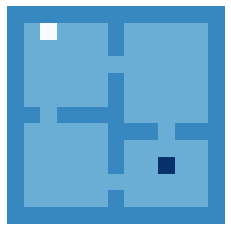

(1, 0.0, False, False, 1)

In [3]:
env = FourRooms(max_steps=100, start_pos=1, goal_pos= 80, mode=EnvMode.TRIVIAL, rendering=True)
env.reset()
env.step(0)

Random trivial actions

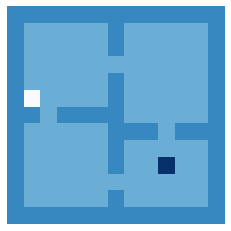

Maximum number of steps reached


In [4]:
visualise_random_episodes(EnvMode.TRIVIAL)

Random hallmark options

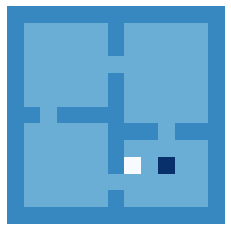

Maximum number of steps reached


In [5]:
visualise_random_episodes(EnvMode.OPTIONS)

Random actions and hallmark options

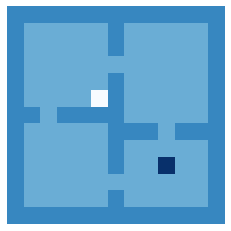

Maximum number of steps reached


In [6]:
visualise_random_episodes(EnvMode.ALL)

### 2. Comparing Learning with and without options

In [51]:
# Parameters
epsilon = 0.1
lr = 1/8
gamma = 0.9
nruns = 50
nepisodes= 10000

Run 1/50 - Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:10<00:00, 924.65it/s]


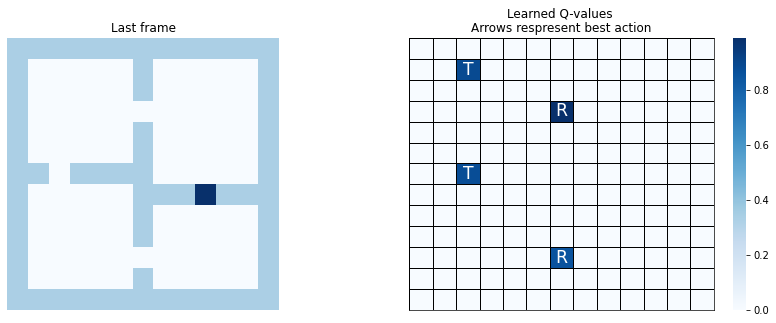

In [52]:
from utils import train_model, postprocess, plot_q_values_map
env = FourRooms(max_steps=1000, mode=EnvMode.OPTIONS, start_pos=1)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns)

st_option = postprocess(steps=steps, nepisodes=nepisodes)
plot_q_values_map(qtable=qtables.mean(axis=0), env=env, map_size=13)

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:18<00:00, 534.97it/s]


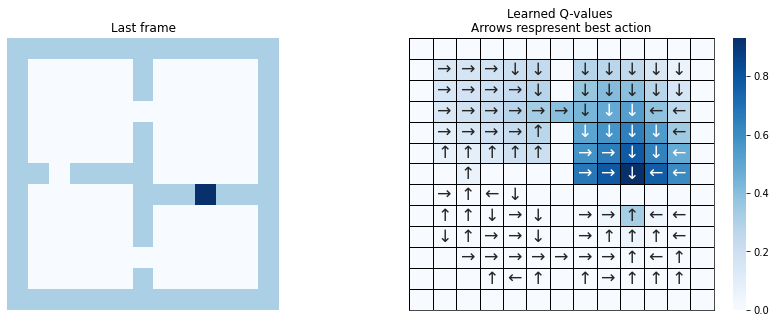

In [53]:
env = FourRooms(max_steps=1000, mode=EnvMode.TRIVIAL, start_pos=1)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns)

st_trivial = postprocess(steps=steps, nepisodes=nepisodes)
plot_q_values_map(qtable=qtables.mean(axis=0), env=env, map_size=13)

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:06<00:00, 1533.18it/s]


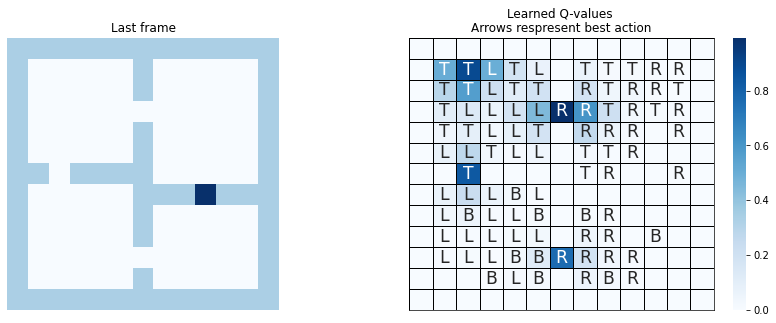

In [54]:
env = FourRooms(max_steps=1000, mode=EnvMode.ALL, start_pos=1)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns)

st_all = postprocess(steps=steps, nepisodes=nepisodes)
plot_q_values_map(qtable=qtables.mean(axis=0), env=env, map_size=13)

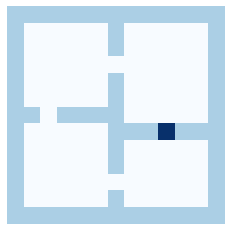

In [10]:
from agents import EpsilonGreedy
policy = EpsilonGreedy(epsilon=epsilon)
qtable = qtables.mean(axis=0)  # Average the Q-table between runs
env.rendering = True
state, _ = env.reset()
done = False
for _ in range(5):
    while True:
        action = policy.choose_action(env.action_space, state, qtable, is_training=False)
        new_state, reward, terminated, truncated, step = env.step(action)
        if terminated or truncated:
            break
    env.reset()


In [57]:
st_trivial

,Episodes,Steps,Std
0,0,611.02,298.571297
1,1,434.08,295.985124
2,2,463.22,276.909320
3,3,544.92,294.680901
4,4,393.76,292.454206
...,...,...,...
9995,9995,22.16,6.715236
9996,9996,24.00,6.086050
9997,9997,21.84,6.500338
9998,9998,20.62,5.552981


In [58]:
st_option["Type"] = "Only Options"
st_option['Moving_Average'] = st_option['Steps'].rolling(window=10).mean()
st_option.loc[:100, "Moving_Average"] = st_option.loc[:100, "Steps"] 

st_option["lower_bound"] = st_option["Moving_Average"]-(1.96*st_option["Std"]/np.sqrt(50))
st_option["upper_bound"] = st_option["Moving_Average"]+(1.96*st_option["Std"]/np.sqrt(50))
st_option["diff"] = st_option["upper_bound"] - st_option["lower_bound"] 

st_trivial["Type"] = "Trivial Actions"
st_trivial['Moving_Average'] = st_trivial['Steps'].rolling(window=10).mean()
st_trivial.loc[:100, "Moving_Average"] = st_trivial.loc[:100, "Steps"] 

st_trivial["lower_bound"] = st_trivial["Moving_Average"]-(1.96*st_trivial["Std"]/np.sqrt(50))
st_trivial["upper_bound"] = st_trivial["Moving_Average"]+(1.96*st_trivial["Std"]/np.sqrt(50))
st_trivial["diff"] = st_trivial["upper_bound"] - st_trivial["lower_bound"] 

st_all["Type"] = "Options + Actions"
st_all['Moving_Average'] = st_all['Steps'].rolling(window=10).mean()
st_all.loc[:100, "Moving_Average"] = st_all.loc[:100, "Steps"] 

st_all["lower_bound"] = st_all["Moving_Average"]-(1.96*st_all["Std"]/np.sqrt(50))
st_all["upper_bound"] = st_all["Moving_Average"]+(1.96*st_all["Std"]/np.sqrt(50))
st_all["diff"] = st_all["upper_bound"] - st_all["lower_bound"] 





In [ ]:
ticks_x = [1, 10, 100, 1000, 10000]
ticks_y = [10, 100, 1000]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax2 = ax1.twinx()
ax2.bar(st_trivial["Episodes"], st_trivial["diff"], alpha=0.5)
ax1.plot(st_trivial["Episodes"], st_trivial['Moving_Average'])

ax2.bar(st_all["Episodes"], st_all["diff"], alpha=0.5,align="center")
ax1.plot(st_all["Episodes"], st_all['Moving_Average'])

ax2.bar(st_option["Episodes"], st_option["diff"], alpha=0.5)
ax1.plot(st_option["Episodes"], st_option['Moving_Average'])

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(ticks_x)
ax1.set_xticklabels(ticks_x)
ax2.set_ylim([0,1000])

ax1.set_yticks(ticks_y)
ax1.set_yticklabels(ticks_y)
plt.show()
sns.barplot(data=df, x='column', y='val', hue='group', ax=ax2)

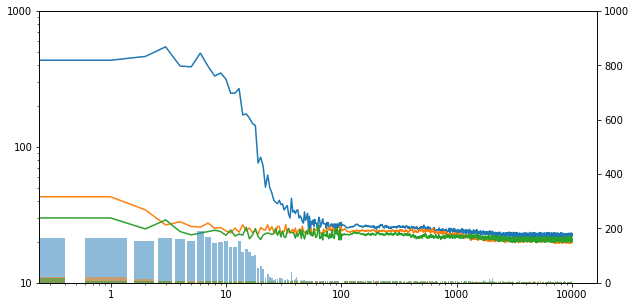

In [61]:
ticks_x = [1, 10, 100, 1000, 10000]
ticks_y = [10, 100, 1000]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax2 = ax1.twinx()
ax2.bar(st_trivial["Episodes"], st_trivial["diff"], alpha=0.5)
ax1.plot(st_trivial["Episodes"], st_trivial['Moving_Average'])

ax2.bar(st_all["Episodes"], st_all["diff"], alpha=0.5,align="center")
ax1.plot(st_all["Episodes"], st_all['Moving_Average'])

ax2.bar(st_option["Episodes"], st_option["diff"], alpha=0.5)
ax1.plot(st_option["Episodes"], st_option['Moving_Average'])

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xticks(ticks_x)
ax1.set_xticklabels(ticks_x)
ax2.set_ylim([0,1000])

ax1.set_yticks(ticks_y)
ax1.set_yticklabels(ticks_y)
plt.show()

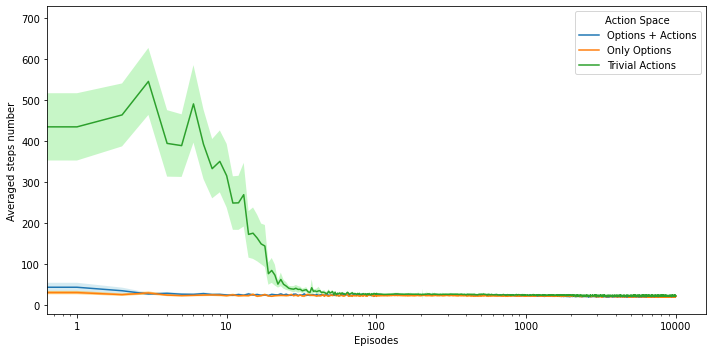

In [68]:
import seaborn as sns
import pandas as pd

st_option["Type"] = "Only Options"
st_option['Moving_Average'] = st_option['Steps'].rolling(window=10).mean()
st_option.loc[:100, "Moving_Average"] = st_option.loc[:100, "Steps"] 

st_trivial["Type"] = "Trivial Actions"
st_trivial['Moving_Average'] = st_trivial['Steps'].rolling(window=10).mean()
st_trivial.loc[:100, "Moving_Average"] = st_trivial.loc[:100, "Steps"] 

st_all["Type"] = "Options + Actions"
st_all['Moving_Average'] = st_all['Steps'].rolling(window=10).mean()
st_all.loc[:100, "Moving_Average"] = st_all.loc[:100, "Steps"] 

st = pd.concat([st_all, st_option, st_trivial])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.fill_between(st_all["Episodes"], st_all["Moving_Average"]-1.96*st_all["Std"]/np.sqrt(50), st_all["Moving_Average"]+1.96*st_all["Std"]/np.sqrt(50), alpha=0.5, facecolor="Lightblue")
ax.fill_between(st_trivial["Episodes"], st_trivial["Moving_Average"]-1.96*st_trivial["Std"]/np.sqrt(50), st_trivial["Moving_Average"]+1.96*st_trivial["Std"]/np.sqrt(50), alpha=0.5, facecolor="Lightgreen")
ax.fill_between(st_option["Episodes"], st_option["Moving_Average"]-1.96*st_option["Std"]/np.sqrt(50), st_option["Moving_Average"]+1.96*st_option["Std"]/np.sqrt(50), alpha=0.5, facecolor="Orange")
ticks_x = [1, 10, 100, 1000, 10000]
#ticks_y = [10, 100, 1000]

sns.lineplot(data=st, x="Episodes", y="Moving_Average", hue="Type", ax=ax)
ax.set(ylabel="Averaged steps number")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xticks(ticks_x)
ax.set_xticklabels(ticks_x)


#ax.set_yticks(ticks_y)
#ax.set_yticklabels(ticks_y)

ax.legend(title="Action Space")
fig.tight_layout()
plt.show()

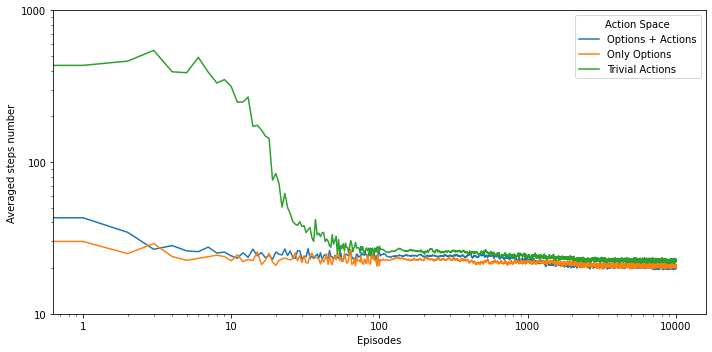

In [69]:
import seaborn as sns
import pandas as pd

def plot_steps(st_all, st_options, st_trivial):
    st_options["Type"] = "Only Options"
    st_options['Moving_Average'] = st_options['Steps'].rolling(window=10).mean()
    st_options.loc[:100, "Moving_Average"] = st_options.loc[:100, "Steps"] 

    st_trivial["Type"] = "Trivial Actions"
    st_trivial['Moving_Average'] = st_trivial['Steps'].rolling(window=10).mean()
    st_trivial.loc[:100, "Moving_Average"] = st_trivial.loc[:100, "Steps"] 

    st_all["Type"] = "Options + Actions"
    st_all['Moving_Average'] = st_all['Steps'].rolling(window=10).mean()
    st_all.loc[:100, "Moving_Average"] = st_all.loc[:100, "Steps"] 

    st = pd.concat([st_all, st_options, st_trivial])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))


    ticks_x = [1, 10, 100, 1000, 10000]
    ticks_y = [10, 100, 1000]

    sns.lineplot(data=st, x="Episodes", y="Moving_Average", hue="Type", ax=ax)
    ax.set(ylabel="Averaged steps number")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(ticks_x)
    ax.set_xticklabels(ticks_x)


    ax.set_yticks(ticks_y)
    ax.set_yticklabels(ticks_y)

    ax.legend(title="Action Space")
    fig.tight_layout()
    plt.show()
plot_steps(st_all, st_option, st_trivial)

Run 1/50 - Episodes:   0%|          | 2/10000 [00:00<09:15, 17.99it/s]

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:19<00:00, 507.98it/s]


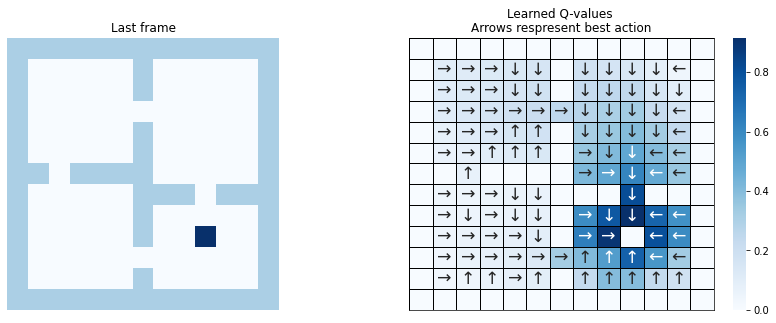

In [70]:
env = FourRooms(max_steps=1000, mode=EnvMode.TRIVIAL, start_pos=1, goal_pos=80)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns)

st_trivial = postprocess(steps=steps, nepisodes=nepisodes)
plot_q_values_map(qtable=qtables.mean(axis=0), env=env, map_size=13)

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:24<00:00, 402.28it/s]


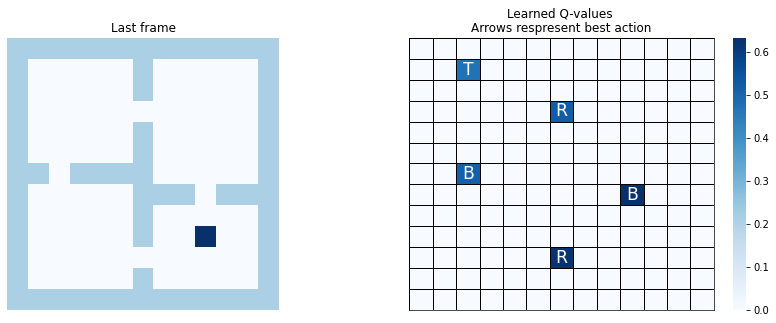

In [71]:
env = FourRooms(max_steps=1000, mode=EnvMode.OPTIONS, start_pos=1, goal_pos=80)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns)

st_options = postprocess(steps=steps, nepisodes=nepisodes)
plot_q_values_map(qtable=qtables.mean(axis=0), env=env, map_size=13)

Run 50/50 - Episodes: 100%|██████████| 10000/10000 [00:12<00:00, 791.01it/s]


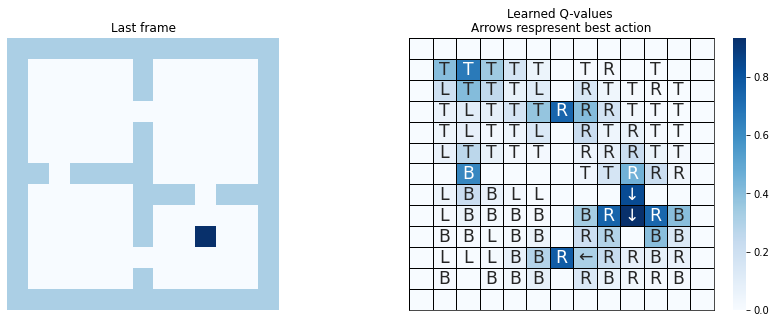

In [72]:
env = FourRooms(max_steps=1000, mode=EnvMode.ALL, start_pos=1, goal_pos=80)
qtables, rewards, steps = train_model(env, lr, gamma, epsilon, nepisodes, nruns)

st_all = postprocess(steps=steps, nepisodes=nepisodes)
plot_q_values_map(qtable=qtables.mean(axis=0), env=env, map_size=13)

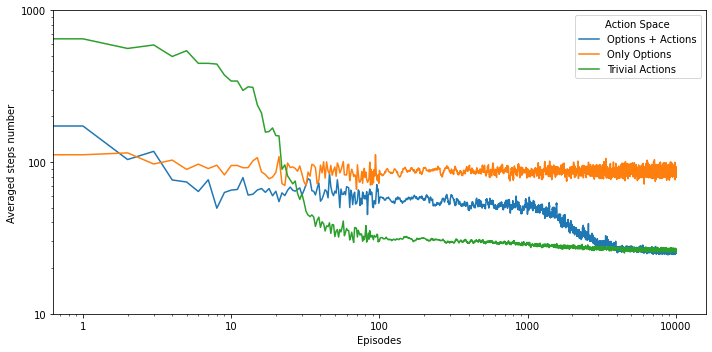

In [73]:
plot_steps(st_all, st_options, st_trivial)

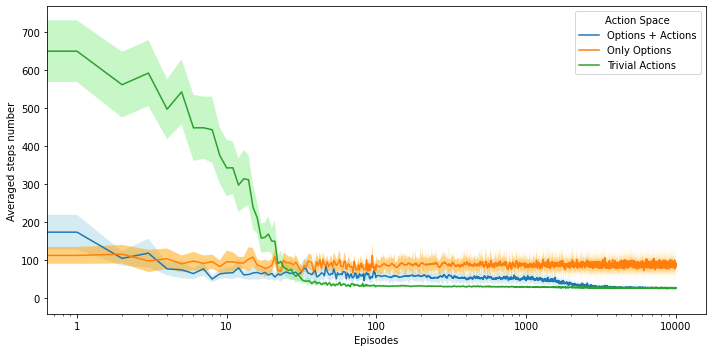

In [75]:
import seaborn as sns
import pandas as pd

st_options["Type"] = "Only Options"
st_options['Moving_Average'] = st_options['Steps'].rolling(window=10).mean()
st_options.loc[:100, "Moving_Average"] = st_options.loc[:100, "Steps"] 

st_trivial["Type"] = "Trivial Actions"
st_trivial['Moving_Average'] = st_trivial['Steps'].rolling(window=10).mean()
st_trivial.loc[:100, "Moving_Average"] = st_trivial.loc[:100, "Steps"] 

st_all["Type"] = "Options + Actions"
st_all['Moving_Average'] = st_all['Steps'].rolling(window=10).mean()
st_all.loc[:100, "Moving_Average"] = st_all.loc[:100, "Steps"] 

st = pd.concat([st_all, st_options, st_trivial])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

ax.fill_between(st_all["Episodes"], st_all["Moving_Average"]-1.96*st_all["Std"]/np.sqrt(50), st_all["Moving_Average"]+1.96*st_all["Std"]/np.sqrt(50), alpha=0.5, facecolor="Lightblue")
ax.fill_between(st_trivial["Episodes"], st_trivial["Moving_Average"]-1.96*st_trivial["Std"]/np.sqrt(50), st_trivial["Moving_Average"]+1.96*st_trivial["Std"]/np.sqrt(50), alpha=0.5, facecolor="Lightgreen")
ax.fill_between(st_options["Episodes"], st_options["Moving_Average"]-1.96*st_options["Std"]/np.sqrt(50), st_options["Moving_Average"]+1.96*st_options["Std"]/np.sqrt(50), alpha=0.5, facecolor="Orange")
ticks_x = [1, 10, 100, 1000, 10000]
#ticks_y = [10, 100, 1000]

sns.lineplot(data=st, x="Episodes", y="Moving_Average", hue="Type", ax=ax)
ax.set(ylabel="Averaged steps number")
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xticks(ticks_x)
ax.set_xticklabels(ticks_x)


#ax.set_yticks(ticks_y)
#ax.set_yticklabels(ticks_y)

ax.legend(title="Action Space")
fig.tight_layout()
plt.show()